# Notebook: Introduction from Gaussian Processes to Bayesian Optimization


## Introduction

As we know, Gaussian Process (GP) is one of the most popular models in the research region of machine learning because it is a non-parametric model and its also provides extra uncertainty. Moreover, GP is an excellent model for low-dimensional problems. Given those merits, Bayesian Optimization was proposed based on GP to solve expensive optimization problems. Within this notebook, we will guide through the basics and realizations from GP to BO.

## 1. Kriging model

### 1.1 Basic of Kriging model (Noiseless case)

**Assume**

$$y = f(\mathrm{x}) = m(\mathrm{x}) + \epsilon$$
where $\epsilon \sim N(0, \sigma_e^2)$ and it's epistemic uncertainty, $m(\mathrm{x})$ is the mean function of observations, in this case set to be constant $\mu$

A Gaussian process if completely specified by its mean function and correlation function, which can be defined as:

$$m(\mathbf{x}) = \mathbb{E}\left [ f \left( \mathbf{x} \right) \right]$$
$$k(\mathbf{x}, \mathbf{x}') = \mathbb{E}\left [ (f (\mathbf{x}) - m(\mathbf{x}) )(f(\mathbf{x}') - m(\mathbf{x}'))\right]$$

Therefore, Gaussian process can be write as:
$$f(\mathbf{x}) \sim  \mathcal{GP} (m(\mathrm{x}), k(\mathrm{x}, \mathrm{x}'))$$

**Kernel function**

A brief introduction to famous kernel function called **radial basis function**, **hyper-parameter estimation**, and **inference**.
**RBF kernel: spatial correlation**
$$k(\mathrm{x}^{i}, \mathrm{x}^{j}) = exp\left(-\sum_{d=1}^{k} \theta_d \left({x}_{d}^{i}-{x}_{d}^{j}\right)^{p_d}\right)$$
where $k$ is the dimension of the problem, $\mathrm{\theta}$ and $\mathrm{p}$ are two $k$-dimensional vectors of parameters. For the illustrated case of this notebook, we assume the value of $\mathrm{p}$ is 2, which means the kernel function is isotropic.
**Correlation matrix**

$$
\mathrm{K}(\mathrm{X,X}) = \begin{bmatrix}
    k(\mathrm{x}^{1}, \mathrm{x}^{1}) & ... & k(\mathrm{x}^{1}, \mathrm{x}^{n})\\
    ... & ... & ...\\
    k(\mathrm{x}^{n}, \mathrm{x}^{1})& ...& k(\mathrm{x}^{n}, \mathrm{x}^{n})
    \end{bmatrix}
$$

where $n$ is the number of samples

## 1.2 Negative Log Likelihood estimation for parameters

**Training by Negative Log Likelihood (NLL)**
$$L = \frac{1}{\left(2\pi \sigma^2\right)|\mathbf{K}|^{\frac{1}{2}}}exp\left(-\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{2\sigma^2} \right)$$
**Take the natural logarithm (NLL):**
$$\ln(L) =-\frac{n}{2}\ln(2\pi) - \frac{n}{2}\ln(\sigma_e^2) - \frac{1}{2}\ln|\mathbf{K}|  -\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{2\sigma_e^2}$$
in which, $2n+2$ parameters needed to be determined.

_First step: take derivative of NLL and set to be zero_
$$\hat{\mu} = \frac{\mathbf{1}^T\mathbf{K}^{-1}\mathbf{y}}{\mathbf{1}^T\mathbf{K}^{-1}\mathbf{1}}, \,\, \hat{\sigma_e}^2 =\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{n} $$

From the expression, the estimated mean is a weighted average of the observations, and the weighted is determined by the Kernel function.

_Second step: optimization for other parameters_
$$\ln(L) = -\frac{n}{2} \ln(\hat{\sigma_e}^2) - \frac{1}{2} \ln |\mathbf{K}|$$

## 1.3 Inference

The prediction of the unseen points should be joint Gaussian with the observations. Therefore:

$$
\begin{bmatrix}
    \mathbf{y} \\ \mathbf{y^{*}}
\end{bmatrix} \sim N \left( \begin{bmatrix}
    m(X) \\ m(X^*)
\end{bmatrix}, \begin{bmatrix}
    K(X,X) & K(X, X^*) \\ K(X^*, X) & K(X^*, X^*)
\end{bmatrix} \right)
$$

**Predictive mean**
$$\mathbf{y^*} = m(X^*) +  K(X^*, X)K(X,X)^{-1}(\mathbf{y} - m(X)) $$

**Predictive variance: Epistemic uncertainty**
$$\mathbf{s^2}^* = \sigma_e^2\left(1-K\left( X^*, X\right )K\left(X,X\right)^{-1}K\left(X, X^*\right)  \right)  $$

## 1.4 Implementation of Kriging model


In [1]:
# third party packages
import matplotlib.pyplot as plt
import numpy as np

# local funstions
from mfpml.models.gaussian_process import GaussianProcessRegression as Kriging
from mfpml.problems.sf_functions import Forrester

In [2]:
# define function
func = Forrester()

# initialize sampler

# x = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
x = np.linspace(0, 1, 8, endpoint=True).reshape((-1, 1))
test_x = np.linspace(0, 1, 1001, endpoint=True).reshape(-1, 1)

# get the function value
y = func.f(x)
test_y = func.f(test_x)

# train the model
kriging = Kriging(design_space=func._input_domain,
                  optimizer_restart=20, noise_prior=0.0)
kriging.train(x, y)
sf_pre, sf_std = kriging.predict(test_x, return_std=True)

In [3]:
# to explore some important parameters
# estimated mean value
mu_estimated = kriging.beta[0, 0]
# sample mean value
sample_y_mean = np.mean(y)
print(f"mu_estimated:{mu_estimated:.4f}, sample_y_mean:{sample_y_mean:.4f}")

# estimated variance
sigma_estimated = kriging.sigma2[0, 0]
# sample variance
sample_y_var = np.var(y)
print(
    f"sigma_estimated:{sigma_estimated:.4f}, sample_y_var:{sample_y_var:.4f}")

# print the parameters
print(f"theta:{kriging.kernel.param}")
print(f"Kernel Matrix: \n {kriging.K}")

mu_estimated:0.4363, sample_y_mean:1.6936
sigma_estimated:1.7800, sample_y_var:33.1184
theta:[20.3001023]
Kernel Matrix: 
 [[1.00000000e+00 6.60810741e-01 1.90681419e-01 2.40266844e-02
  1.32200622e-03 3.17634262e-05 3.33254001e-07 1.52678396e-09]
 [6.60810741e-01 1.00000000e+00 6.60810741e-01 1.90681419e-01
  2.40266844e-02 1.32200622e-03 3.17634262e-05 3.33254001e-07]
 [1.90681419e-01 6.60810741e-01 1.00000000e+00 6.60810741e-01
  1.90681419e-01 2.40266844e-02 1.32200622e-03 3.17634262e-05]
 [2.40266844e-02 1.90681419e-01 6.60810741e-01 1.00000000e+00
  6.60810741e-01 1.90681419e-01 2.40266844e-02 1.32200622e-03]
 [1.32200622e-03 2.40266844e-02 1.90681419e-01 6.60810741e-01
  1.00000000e+00 6.60810741e-01 1.90681419e-01 2.40266844e-02]
 [3.17634262e-05 1.32200622e-03 2.40266844e-02 1.90681419e-01
  6.60810741e-01 1.00000000e+00 6.60810741e-01 1.90681419e-01]
 [3.33254001e-07 3.17634262e-05 1.32200622e-03 2.40266844e-02
  1.90681419e-01 6.60810741e-01 1.00000000e+00 6.60810741e-01]
 [

# 2 Gaussian Process (Noise case)

## 2.1 basics of Gaussian process

The above mentioned Kriging model is a specific Gaussian Process model for handling deterministic functions/problems. While there are uncertainties within responses because of the data-collection manner like manufacturing, fabrication, and so on, and those uncertainties can not been eliminated even when the amount of data increasing. Therefore, this is called aleatoric uncertainty, also data uncertainty.

<img src="figures\noise_illustration.png" title="Noise responses problems" width="50%" align="right">

**Assumption**

The assumption of a Gaussian Process model for above needs to be changed, which can be expressed as:
$$\mathbf{y} = f(\mathrm{x}) + noise$$

where noise usually is normal distributed with $ N\left(0, \sigma_a^2\right)$, and we usually refer it as data (aleatoric uncertainty). One has to mention that the first part of the above expression ($f(\mathrm{x})$) is can be learnt by Kriging model, and also the noise of can be regarded as white noise which is independent on the input $\mathrm{x}$.

Therefore the mix-kernel Gaussian process is developed:

- RBF kernel to learn $f(\mathrm{x})$
- white noise kernel to learn noise

Noise subjects to $N\left(0, \sigma_a^2 \right)$, and noise is independently added to the outputs. Therefore, white noise kernel is proposed, which is defined by

$$k(\mathrm{x}, \mathrm{x}') = \sigma_a^2 \delta(\mathrm{x}, \mathrm{x}')$$

Intuitively, the white noise Correlation matrix is a diagonal matrix with
diagonal elements $ \sigma_a^2$

## 2.2 Training, Inference of Gaussian Process

Simply to say, mix-kernel Gaussian process only changes its kernel combining two difference kernels compared with Kriging.

**Mix-kernel**

$$K_{mix}\left (\mathbf{X}, \mathbf{X} \right) =K_{RBF}\left (\mathbf{X}, \mathbf{X} \right)  + K_{noise}\left (\mathbf{X}, \mathbf{X} \right)  $$

**Training**

Training process is same as Kriging model

**Inference**

-Predictive mean
$$\mathbf{y^*} = m(X^*) +  K(X^*, X)K(X,X)^{-1}(\mathbf{y} - m(X)) $$

-Predicted variance
$$\mathbf{s^2}^* = \sigma_e^2\left(1-K\left( X^*, X\right )K\left(X,X\right)^{-1}K\left(X, X^*\right)  \right) + \sigma_a^2 $$

## 2.3 Implementation


In [4]:
# import necessary functions from mfpml
from mfpml.models.gaussian_process import GaussianProcessRegression as GaussianProcess
from mfpml.design_of_experiment.sf_samplers import LatinHyperCube

In [5]:
# sampling by sampling method
sampler = LatinHyperCube(design_space=func.input_domain)
sample_x = sampler.get_samples(num_samples=60, seed=0)
test_x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# get samples by adding noise to the true function
sample_y = func.f(sample_x) + np.random.normal(0, 0.2,
                                               sample_x.shape[0]).reshape((-1, 1))
test_y = func.f(test_x) + np.random.normal(0, 0.2,
                                           test_x.shape[0]).reshape((-1, 1))
test_mean = func.f(test_x)

In [6]:

# initialize the regressor
gp = GaussianProcess(design_space=func._input_domain,
                     noise_prior=None, optimizer_restart=20)
# train the model
gp.train(sample_x, sample_y)
# get the prediction
gp_pre, gp_std = gp.predict(test_x, return_std=True)

In [7]:
# to explore some important parameters
# estimated mean value
mu_estimated = gp.beta[0, 0]
# sample mean value
sample_y_mean = np.mean(sample_y)
print(f"mu_estimated:{mu_estimated:.4f}, sample_y_mean:{sample_y_mean:.4f}")

# estimated variance
sigma_estimated = gp.sigma2[0, 0]
# sample variance
sample_y_var = np.var(sample_y)
print(
    f"sigma_estimated:{sigma_estimated:.4f}, sample_y_var:{sample_y_var:.4f}")

# print the parameters
print(f"theta:{gp.kernel.param}")
print(f"Kernel Matrix: \n {gp.K}")

# learned noise
print(f" learnt noise:{gp.noise:.4f}")

mu_estimated:0.5412, sample_y_mean:0.4828
sigma_estimated:1.1257, sample_y_var:19.7183
theta:[33.0496241]
Kernel Matrix: 
 [[1.00176483e+00 2.70958017e-06 1.51284881e-03 ... 7.37415176e-12
  1.48945063e-02 5.65549157e-07]
 [2.70958017e-06 1.00176483e+00 3.44692745e-01 ... 1.11018611e-01
  9.64519904e-02 9.55850368e-01]
 [1.51284881e-03 3.44692745e-01 1.00176483e+00 ... 1.79396692e-03
  7.80942325e-01 2.12490000e-01]
 ...
 [7.37415176e-12 1.11018611e-01 1.79396692e-03 ... 1.00176483e+00
  1.14910865e-04 1.99263096e-01]
 [1.48945063e-02 9.64519904e-02 7.80942325e-01 ... 1.14910865e-04
  1.00176483e+00 4.81327426e-02]
 [5.65549157e-07 9.55850368e-01 2.12490000e-01 ... 1.99263096e-01
  4.81327426e-02 1.00176483e+00]]
 learnt noise:0.1865


## 2.4 More interesting properties of Gaussian Process

The above mentioned cases of Gaussian Process model is trained on uniform distributed samples and we only showed the prediction within the interpolate region. In this section, we will show the prediction of Gaussian Process model on non-uniform distributed samples and extrapolate region. And we adopt mix-model Gaussian Process model for illustration.

**Non-uniform distributed samples**


In [8]:
# for the above problem, we can assume that we sample from [0.2,0.4] and [0.7,0.8] with same noise level.
sample_x1 = np.linspace(0.2, 0.4, 20, endpoint=True).reshape((-1, 1))
sample_x2 = np.linspace(0.6, 0.8, 20, endpoint=True).reshape((-1, 1))
sample_nonuniform_x = np.vstack((sample_x1, sample_x2))
sample_nonuniform_y = func.f(sample_nonuniform_x) + np.random.normal(
    0, 0.2, sample_nonuniform_x.shape[0]).reshape((-1, 1))

# initialize the regressor
gp_nonuniform = GaussianProcess(
    design_space=func._input_domain, optimizer_restart=20, noise_prior=None)
# train the model
gp_nonuniform.train(sample_nonuniform_x, sample_nonuniform_y)
# get the prediction
gp_nonuniform_pre, gp_nonuniform_std = gp_nonuniform.predict(
    test_x, return_std=True)

In [9]:
# to explore some important parameters
# estimated mean value
mu_estimated = gp_nonuniform.beta[0, 0]
# sample mean value
sample_y_mean = np.mean(sample_nonuniform_y)
print(f"mu_estimated:{mu_estimated:.4f}, sample_y_mean:{sample_y_mean:.4f}")

# estimated variance
sigma_estimated = gp_nonuniform.sigma2[0, 0]
# sample variance
sample_y_var = np.var(sample_nonuniform_y)
print(
    f"sigma_estimated:{sigma_estimated:.4f}, sample_y_var:{sample_y_var:.4f}")

# learned noise
print(f"learnt noise:{gp_nonuniform.noise:.4f}")

mu_estimated:0.3938, sample_y_mean:-2.0113
sigma_estimated:1.0156, sample_y_var:5.4995
learnt noise:0.1934


From the above illustration, we can see the prediction at within the region of samples is good, it across the samples. Moreover, the predictive uncertainty of this region could cover the variation of the samples. From the learnt noise, we can see the learnt noise is close to the true noise. More interestingly, the predictive uncertainty of the extrapolate region is increasing, the magnitude of the predictive uncertainty arise when the predicted location is far away from the samples.\

**Explore extrapolate properties**

Let's recall the implementation from 1.4 and 2.3, where we think the prediction is good in the interpolate region. In this part, we want to enlarge the predictive region to see how the predictive uncertainty changes. Meanwhile, the formula of the Forrester function is given as:
$$y = \left(6x-2 \right)^2\sin(12x-4) + \varepsilon, \,\, \varepsilon \sim N(0, 0.2)$$


In [10]:
# generate test samples in the regions of [-1, 2]
test_x = np.linspace(-1, 2, 101, endpoint=True).reshape(-1, 1)
# get test responses for the noiseless case
test_y = func.f(test_x)

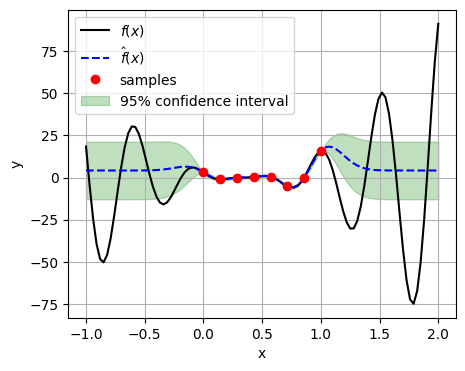

In [11]:
# noiseless case (krging model)
sf_pre, sf_std = kriging.predict(test_x, return_std=True)

# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(x, y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Extroplation with different basis function**

In the following cases, we actually assume that basis function of Gaussian process is an ordinary function. In other word, we are using
a constant to learning the trend of a function, and using a Gaussian process to learn the residual. What if we use other format basis function to learn the deterministic part, such as Linear basis function, Quadratic basis function, and so on.


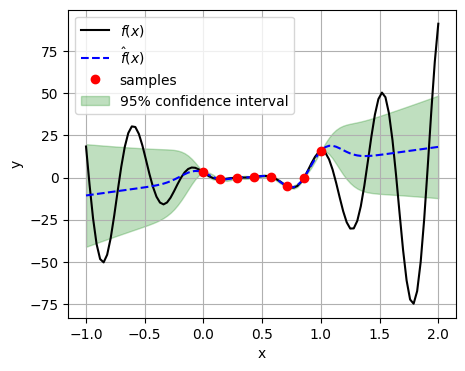

In [12]:
# Use Linear basis function
from mfpml.models.basis_functions import Linear
kriging_linear = Kriging(design_space=func._input_domain,
                         noise_prior=0.0,
                         regr=Linear(), optimizer_restart=20)
kriging_linear.train(X=x, Y=y)
sf_pre_linear, sf_std_linear = kriging_linear.predict(test_x, return_std=True)

# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre_linear, "b--", label=r"$\hat{f}(x)$")
ax.plot(x, y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre_linear - 1.96 * sf_std_linear).reshape(-1),
    (sf_pre_linear + 1.96 * sf_std_linear).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
# show the predictive value at (-1.0 and 2.0)
print(f"Predictive value at -1.0: {sf_pre[0]}")
print(f"Predictive value at 2.0: {sf_pre[-1]}")

# learnt mean
print(f"learnt beta: {kriging_linear.beta[:]}")

# predicted standard deviation at -1.0 and 2.0
print(f"Predictive standard deviation at -1.0: {sf_std[0]}")
print(f"Predictive standard deviation at 2.0: {sf_std[-1]}")

# learnt std
print(f"learnt variance: {np.sqrt(kriging_linear.sigma2)}")

Predictive value at -1.0: [4.20467069]
Predictive value at 2.0: [4.20467071]
learnt beta: [[-0.46854212]
 [ 1.66990317]]
Predictive standard deviation at -1.0: [8.70604816]
Predictive standard deviation at 2.0: [8.70604816]
learnt variance: [[1.16655539]]


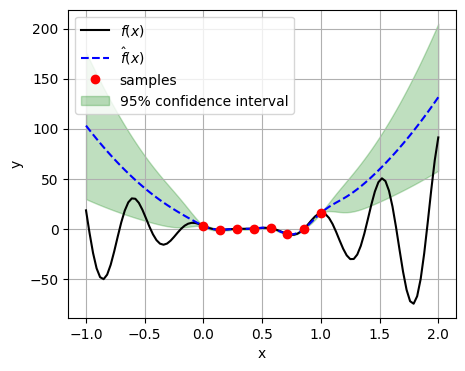

In [14]:
# Use Quadratic basis function
from mfpml.models.basis_functions import Quadratic
kriging_quadratic = Kriging(
    design_space=func._input_domain, regr=Quadratic(), noise_prior=0.0,  optimizer_restart=20)
kriging_quadratic.train(X=x, Y=y)
sf_pre_quadratic, sf_std_quadratic = kriging_quadratic.predict(
    test_x, return_std=True)

# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre_quadratic, "b--", label=r"$\hat{f}(x)$")
ax.plot(x, y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre_quadratic - 1.96 * sf_std_quadratic).reshape(-1),
    (sf_pre_quadratic + 1.96 * sf_std_quadratic).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [15]:
# show the predictive value at (-1.0 and 2.0)
print(f"Predictive value at -1.0: {sf_pre[0]}")
print(f"Predictive value at 2.0: {sf_pre[-1]}")

# learnt mean
print(f"learnt beta: {kriging_quadratic.beta[:]}")

# predicted standard deviation at -1.0 and 2.0
print(f"Predictive standard deviation at -1.0: {sf_std[0]}")
print(f"Predictive standard deviation at 2.0: {sf_std[-1]}")

# learnt std
print(f"learnt variance: {np.sqrt(kriging_quadratic.sigma2)}")

Predictive value at -1.0: [4.20467069]
Predictive value at 2.0: [4.20467071]
learnt beta: [[ 0.56686852]
 [-7.70558536]
 [ 9.34869669]]
Predictive standard deviation at -1.0: [8.70604816]
Predictive standard deviation at 2.0: [8.70604816]
learnt variance: [[0.73070816]]


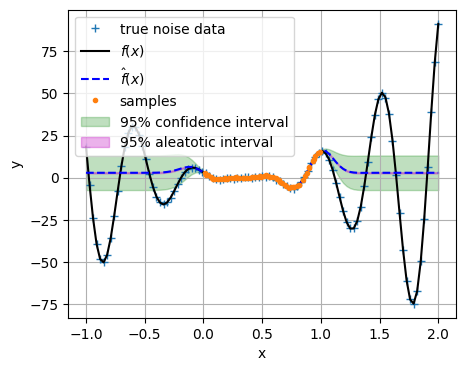

In [16]:
# re-evaluate the function for test samples with noise
test_y = func.f(test_x) + np.random.normal(0, 0.2, test_x.shape[0]).reshape(
    (-1, 1))

# noise case
gp_pre, gp_std = gp.predict(test_x, return_std=True)

# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "+", label="true noise data")
ax.plot(test_x, func.f(test_x), "k-", label=r"$f(x)$")
ax.plot(test_x, gp_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, ".", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (gp_pre - 1.96 * gp_std).reshape(-1),
    (gp_pre + 1.96 * gp_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.fill_between(
    test_x.reshape(-1),
    (gp_pre - 1.96 * gp.noise).reshape(-1),
    (gp_pre + 1.96 * gp.noise).reshape(-1),
    alpha=0.3,
    color="m",
    label="95% aleatotic interval",
)
ax.legend(loc="best")
ax.grid('--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [17]:
# show the predictive value at (-1.0 and 2.0)
print(f"Predictive value at -1.0: {gp_pre[0]}")
print(f"Predictive value at 2.0: {gp_pre[-1]}")

# learnt mean
print(f"learnt mean: {gp.beta}")

# predicted standard deviation at -1.0 and 2.0
print(f"Predictive standard deviation at -1.0: {gp_std[0]}")
print(f"Predictive standard deviation at 2.0: {gp_std[-1]}")

# learnt std
print(f"learnt variance: {np.sqrt(gp.sigma2)}")

Predictive value at -1.0: [2.88596209]
Predictive value at 2.0: [2.8859621]
learnt mean: [[0.54117936]]
Predictive standard deviation at -1.0: [5.23287396]
Predictive standard deviation at 2.0: [5.23287396]
learnt variance: [[1.06096683]]


According the above showcases, we can see that the prediction of Gaussian Process for both noise and noiseless are not good in the extrapolate regions. Plus, the prediction mean of Gaussian process will finally converge to the learnt mean function, in the case, a constant mean function is assumed, so the predictive mean a flat when the predicted location is far away from the samples. Moreover, the predictive uncertainty has same pattern.


# 3 Bayesian Optimization

## 3.1 Introduction

Bayesian optimization is a powerful tool to handling expensive optimization problems. The basic idea of Bayesian optimization is to use Gaussian Process model to approximate the objective function, and then use the predictive mean and variance to determine the next sampling location.

The criterion of Bayesian optimization is called acquisition function, which is a function of predictive mean and variance. The acquisition function is used to determine the next sampling location. There are several acquisition functions, such as Expected Improvement (EI), Probability of Improvement (PI), Lower Confidence Bound (UCB), and so on.

**Note**: Bayesian optimization can be used for both deterministic and stochastic problems. In this notebook, we will only focus on deterministic problems.

---

## 3.2 Acquisition function

**Expected Improvement (EI)**
$$EI(\mathbf{x}) = \mathbb{E}\left [ \max(0, \hat{f}(\mathbf{x}) - f(\mathbf{x}^+)) \right]$$
where $\mathbf{x}^+$ is the best observation so far. The above expression can be simplified as:

$$
EI(\mathbf{x}) = \left\{
\begin{aligned}
&(\hat{f}(\mathbf{x}) - f(\mathbf{x}^+))\Phi(Z) + \hat{s}(\mathbf{x})\phi(Z), \,\, \hat{s}(\mathbf{x}) > 0\\
&0, \,\, \hat{s}(\mathbf{x}) = 0
\end{aligned}
\right.
\,\,
where \,\, Z = \frac{\hat{f}(\mathbf{x}) - f(\mathbf{x}^+) }{\hat{s}(\mathbf{x})}
$$

where $\Phi$ and $\phi$ are the cumulative distribution function and probability density function of standard normal distribution, respectively.

**Probability of Improvement (PI)**
$$PI(\mathbf{x}) = \mathbb{P}\left [ \hat{f}(\mathbf{x}) \geq f(\mathbf{x}^+) \right]$$

$$
PI(\mathbf{x}) = \left\{
\begin{aligned}
&\Phi(Z), \,\, \hat{s}(\mathbf{x}) > 0\\
&0, \,\, \hat{s}(\mathbf{x}) = 0
\end{aligned}
\right.
\,\,
where \,\, Z = \frac{\hat{f}(\mathbf{x}) - f(\mathbf{x}^+) }{\hat{s}(\mathbf{x})}
$$

**Lower Confidence Bound (LCB)**
$$LCB(\mathbf{x}) = \hat{f}(\mathbf{x}) - \kappa \hat{s}(\mathbf{x})$$
where $\kappa$ is a hyper-parameter, which is usually set to be 2.

## 3.3 Schematics of Acquisition function on Forrester function


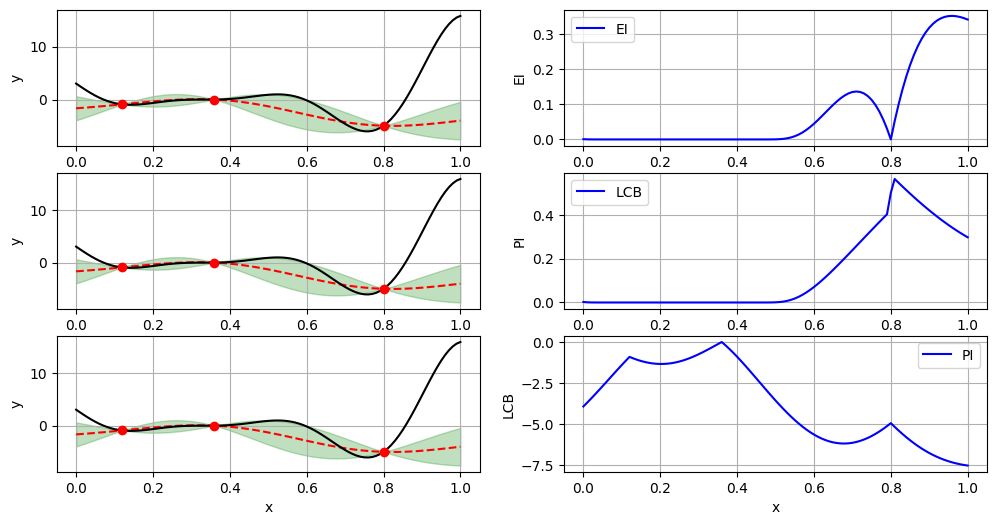

In [18]:
# import necessary functions from mfpml
from mfpml.optimization.sf_uncons_acqusitions import EI, LCB, PI

# for better illustration we want to reduce samples of kriging model
x = np.array([0.12, 0.36, 0.8]).reshape((-1, 1))
y = func.f(x)
# train the model
kriging = Kriging(design_space=func._input_domain)
kriging.train(x, y)

# regenerate test samples within[0,1]
test_x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)
test_y = func.f(test_x)

# get kriging prediction
kriging_pre, kriging_std = kriging.predict(test_x, return_std=True)

# initialize the acqusition function
ei = EI()
lcb = LCB()
pi = PI()
# get the acqusition value for the test samples
ei_value = -ei.eval(test_x, kriging)
lcb_value = lcb.eval(test_x, kriging)
pi_value = -pi.eval(test_x, kriging)

# plot the acquisition functions in three subplots
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
ax[0, 0].plot(test_x, kriging_pre, "r--", label=r"$\hat{f}(x)$")
ax[0, 0].plot(test_x, test_y, "k-", label=r"$f(x)$")
ax[0, 0].plot(x, y, "ro", label="samples")
ax[0, 0].fill_between(
    test_x.reshape(-1),
    (kriging_pre - 1.96 * kriging_std).reshape(-1),
    (kriging_pre + 1.96 * kriging_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax[0, 0].grid()
ax[0, 0].set_xlabel("x")
ax[0, 0].set_ylabel("y")
ax[0, 1].plot(test_x, ei_value, "b-", label="EI")
ax[0, 1].legend(loc="best")
ax[0, 1].grid()
ax[0, 1].set_xlabel("x")
ax[0, 1].set_ylabel("EI")
# for PI
ax[1, 0].plot(test_x, kriging_pre, "r--", label=r"$\hat{f}(x)$")
ax[1, 0].plot(test_x, test_y, "k-", label=r"$f(x)$")
ax[1, 0].plot(x, y, "ro", label="samples")
ax[1, 0].fill_between(
    test_x.reshape(-1),
    (kriging_pre - 1.96 * kriging_std).reshape(-1),
    (kriging_pre + 1.96 * kriging_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax[1, 0].grid()
ax[1, 0].set_xlabel("x")
ax[1, 0].set_ylabel("y")
ax[1, 1].plot(test_x, pi_value, "b-", label="LCB")
ax[1, 1].legend(loc="best")
ax[1, 1].grid()
ax[1, 1].set_xlabel("x")
ax[1, 1].set_ylabel("PI")
# for LCB
ax[2, 0].plot(test_x, kriging_pre, "r--", label=r"$\hat{f}(x)$")
ax[2, 0].plot(test_x, test_y, "k-", label=r"$f(x)$")
ax[2, 0].plot(x, y, "ro", label="samples")
ax[2, 0].fill_between(
    test_x.reshape(-1),
    (kriging_pre - 1.96 * kriging_std).reshape(-1),
    (kriging_pre + 1.96 * kriging_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax[2, 0].grid()
ax[2, 0].set_xlabel("x")
ax[2, 0].set_ylabel("y")
ax[2, 1].plot(test_x, lcb_value, "b-", label="PI")
ax[2, 1].legend(loc="best")
ax[2, 1].grid()
ax[2, 1].set_xlabel("x")
ax[2, 1].set_ylabel("LCB")
plt.savefig("acqusition_functions.png", dpi=300, bbox_inches="tight")
plt.show()

From the above illustration, the kriging model is modelled by 4 samples, and the predictive mean and variance are shown in the left figure. The right figure shows the acquisition function of EI, PI, and LCB. All the acquisition functions are multi-modal function, which aims to balance the exploration and exploitation. To be more specific, the exploration is trying to explore the region where the predictive variance is large, and the exploitation is trying to exploit the region where the predictive mean approach to the best observation so far $f(\mathrm{x}^+)$.

**Get the next sampling location**

The next sampling location is determined by maximizing (i.e. EI and PI) or minimizing (LCb) the acquisition function. Because the acquisition function can be regarded as an analytical function after the Gaussian process model is trained, so the optimization of the acquisition function can be done by an optimization algorithm, such as Particle Swarm Optimization (PSO), Genetic Algorithm (GA), and so on.

## 3.4 Implementation of Bayesian Optimization


In [20]:
# import necessary functions from mfpml
from mfpml.optimization.sf_uncons_bo import BayesUnConsOpt

# initialize the Bayesian optimization
bayes_opt = BayesUnConsOpt(problem=func,
                           acquisition=EI(),
                           num_init=3,
                           verbose=True,
                           seed=4)
bayes_opt.run_optimizer(max_iter=10, stopping_error=0.01)

============= Best objective value at initial samples =========
 
best_y: -3.418439
best_x: [0.67458543]
error: 0.4322228507806462
min_index: 3
============= Best objective value at iteration 1 =========
best_y: -5.741401
best_x: [0.77949142]
error: 0.046396
min_index: 3
============= Best objective value at iteration 2 =========
best_y: -5.741401
best_x: [0.77949142]
error: 0.046396
min_index: 3
============= Best objective value at iteration 3 =========
best_y: -5.741401
best_x: [0.77949142]
error: 0.046396
min_index: 6
============= Best objective value at iteration 4 =========
best_y: -5.931030
best_x: [0.74402331]
error: 0.014900
min_index: 7
============= Best objective value at iteration 5 =========
best_y: -6.020722
best_x: [0.75706685]
error: 0.000003


(-6.020722393567525, array([0.75706685]))

In [27]:
#  print the best value
print(
    f"best value of this function: {func.optimum}, best_x: {func.optimum_scheme}")
print(
    f"best value found by bayesian optimization: {bayes_opt.best:2f}, best_x: {bayes_opt.best_x.item():2f}")

best value of this function: -6.02074, best_x: [0.757248757841856]
best value found by bayesian optimization: -6.020722, best_x: 0.757067


# 4 Summary

This notebook shows basics of Gaussian process model and bayesian optimization, from basics and how to implement those models using the `mfpml` package. The packages is still under development, if you have any questions, please contact the author.
